# **Final Stage - Face recognition**
### **Libraries**

In [71]:
# "Standard" libraries
import os
import pandas as pd
import numpy as np
import pickle
from PIL import Image, ImageOps
import time
import matplotlib.pyplot as plt

# Tensorflow and co
import tensorflow as tf
from tensorflow.keras import layers, models

# Scikit learn and co
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

# Collect the source file location
dir_path = os.path.dirname(os.path.realpath(__name__))

### **Import images**

In [2]:
# Import all the paths
df = pd.DataFrame(os.listdir(os.path.join(dir_path, "working")), columns=["path"])

# Process the path to get the name of the actor
df["name"] = df["path"].apply(lambda x: x.split("-")[0].removesuffix(".jpg").strip("0123456789_"))

# Create a mapping from an actor to a number
nameToIntDict:dict[int,str] = {name:i for i, name in enumerate(df["name"].unique())}
intToNameDict:dict[str,int] = {i:name for name, i in nameToIntDict.items()}

# Map the actor to its id
df["actorID"] = df["name"].map(nameToIntDict)

# Check if everything's fine
df.head()


,path,name,actorID
0,Adriana Lima0_0.jpg-person-nn-bb-44.4703826904...,Adriana Lima,0
1,Adriana Lima101_3.jpg-person-nn-bb-13.88998031...,Adriana Lima,0
2,Adriana Lima102_4.jpg-person-nn-bb-22.29929542...,Adriana Lima,0
3,Adriana Lima103_5.jpg-person-nn-bb-29.93367195...,Adriana Lima,0
4,Adriana Lima104_6.jpg-person-nn-bb-14.91487789...,Adriana Lima,0


### **Train Test Split**
We observe that the proportions within the the classes are not really uniform. Additionally taking randomly within the dataframe to create the training/test set may lead to some classes being overshadowed (not taken in either the training or the test set). For that, we will take a defined proportion of each classes within the training set. 

In [3]:
# Manipulate the seed and the random component
seed = 0
rng = np.random.RandomState(seed)
trainProportion = 0.8

# Initialise the training set and the test set
trainingSet:pd.DataFrame = []
testSet:pd.DataFrame = []

# For each actor id
for i in intToNameDict.keys():
    # Get the sub dataframe corresponding to the actor id
    subDF = df.loc[df["actorID"]==i]
    
    # Get trainProportion (80% by default) of the sub dataframe for training and the other for test set 
    trainIndices = rng.choice([True, False], subDF.shape[0], replace=True, p=[trainProportion, 1-trainProportion])
    trainingSet.append(subDF.loc[trainIndices])
    testSet.append(subDF.loc[~trainIndices])

# Merge the training set of all the actor, do the same for the test set
trainingSet = pd.concat(trainingSet).sample(frac=1, random_state=seed).reset_index()
testSet = pd.concat(testSet).sample(frac=1, random_state=seed).reset_index()

# Check if everything went good.
trainingSet.head()

,index,path,name,actorID
0,14129,Robert De Niro6_789.jpg-person-nn-bb-21.760091...,Robert De Niro,85
1,8592,Katharine Mcphee196_1599.jpg-person-nn-bb-12.8...,Katharine Mcphee,52
2,9688,Lili Reinhart108_2721.jpg-person-nn-bb-54.8482...,Lili Reinhart,58
3,394,Alexandra Daddario131_246.jpg-person-nn-bb-59....,Alexandra Daddario,2
4,8665,Katharine Mcphee69_1672.jpg-person-nn-bb-39.25...,Katharine Mcphee,52


### **Simple CNN** 

In [10]:
# https://www.tensorflow.org/tutorials/images/cnn?hl=fr
num_classes = len(intToNameDict)

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# Dense layer
#model.add(layers.Flatten())
model.add(layers.GlobalAveragePooling2D()) # Flatten is too heavy with images of this size
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(num_classes))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models and Applications\Project\AIModelsAndApplication20252026M1InfoIA\src\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 52, 52, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 64)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 105)            │         6,825 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,729 (260.66 KB)

 Trainable params: 66,729 (260.66 KB)

 Non-trainable params: 0 (0.00 B)

### **Training model**
##### **A - Load images as batches**

In [11]:
def loadImageBatch(pathSet:pd.DataFrame, resizeDim:tuple[int] = (224, 224), equalize:bool = False) -> tuple[list[np.ndarray], list[int]]:
    
    # Initialise the batches
    imBatch = []
    imLabelBatch = []
    
    # For each element in the batch
    for row in pathSet.loc[:, ["path", "actorID"]].iterrows():
        # Get its label
        imLabelBatch.append(row[1].iloc[1])

        # Open the image
        with Image.open(os.path.join(dir_path, "working", row[1].iloc[0])) as im:
            im = im.convert("L") # Convert to grayscale
            im = im.resize(resizeDim) # Resize image
            if equalize:
                im = ImageOps.equalize() # Equalize the luminosity accross the pictures
            imBatch.append(np.asarray(im)/255.) # Transform into array and normaliser between 0 and 1

    return imBatch, imLabelBatch

# Check if it seems fine
loadImageBatch(trainingSet.iloc[:2,:])

([array([[0.15294118, 0.14901961, 0.14117647, ..., 0.28627451, 0.28235294,
          0.28235294],
         [0.14901961, 0.14509804, 0.1372549 , ..., 0.3254902 , 0.3254902 ,
          0.3254902 ],
         [0.14509804, 0.14117647, 0.12941176, ..., 0.37647059, 0.38039216,
          0.38431373],
         ...,
         [0.61960784, 0.60392157, 0.56862745, ..., 0.58039216, 0.45098039,
          0.38823529],
         [0.58823529, 0.56078431, 0.50196078, ..., 0.61176471, 0.47843137,
          0.41176471],
         [0.57254902, 0.5372549 , 0.46666667, ..., 0.63921569, 0.49411765,
          0.42352941]], shape=(224, 224)),
  array([[0.28627451, 0.28235294, 0.2745098 , ..., 0.26666667, 0.25490196,
          0.24705882],
         [0.2627451 , 0.25882353, 0.25882353, ..., 0.26666667, 0.25490196,
          0.25098039],
         [0.19607843, 0.2       , 0.21176471, ..., 0.27058824, 0.2627451 ,
          0.2627451 ],
         ...,
         [0.71372549, 0.70980392, 0.69803922, ..., 0.1254902 , 0.12549

##### **B-Training Loop**

In [ ]:
# Get the loss function with cross entropy
lossFunction = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# Get the optimizer Adam
optimizer = tf.keras.optimizers.Adam()

# Optimize accuracy for training set
trainAccuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Function to manage the training step
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # Pass forward and loss computation
        logits = model(images, training = True)
        loss = lossFunction(labels, logits)
    
    # Compute and apply gradients
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    # Update the training accuracy
    trainAccuracy.update_state(labels, logits)
    
    return loss

# Optimize validation accuracy (validation = training set)
validationAccuracy = tf.keras.metrics.SparseCategoricalAccuracy()

# Function to update the evaluation part (pass forward and test accuracy)
@tf.function
def val_step(images, labels) -> None:
    logits = model(images, training=False)
    validationAccuracy.update_state(labels, logits)
    



##### TRAINING LOOP
# Config
epochs = 200
batchSize = 100
batchNumber = float(trainingSet.shape[0]/batchSize).__ceil__()

# Records the performances over epochs
trainAccuracyPerEpoch = []
validationAccuracyPerEpoch = []
begin = time.time()

# For each epoch
for epoch in range(epochs):
    print(f"Epoch {epoch}/{epochs}")
    
    # Initialise everything
    trainAccuracy.reset_state()
    validationAccuracy.reset_state()
    epochLoss = 0.0
    
    # Go within Training loop. For each batch
    for batch in range(batchNumber):
        if batch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Batch {batch}/{batchNumber}, [{time.time()-begin:.5f}s]")
        
        # Load the batch
        images, labels = loadImageBatch(trainingSet.iloc[batch*batchSize:(batch+1)*batchSize,:])
        
        # Perform the training step and update
        loss = train_step(tf.stack(images), tf.convert_to_tensor(labels, dtype=tf.int32))
        epochLoss += loss.numpy()
    
    # Update average loss on the epoch
    epochLoss /= batchNumber
    
    # Store metrics
    trainAccuracyPerEpoch.append(trainAccuracy.result().numpy())
    print(f"[TRAIN] Loss: {epochLoss:.4f}, Accuracy: {trainAccuracyPerEpoch[-1]:.4f} [{time.time()-begin:.5f}s]")
    
    # Evaluation loop (similar to the training loop above, but don't update the weights)
    for batch in range(batchNumber):
        if batch % 10 == 0:
            print(f"Epoch {epoch}/{epochs}, Batch {batch}/{batchNumber}, [{time.time()-begin:.5f}s]")
        images, labels = loadImageBatch(trainingSet.iloc[batch*batchSize:(batch+1)*batchSize,:])
        loss = val_step(tf.stack(images), tf.convert_to_tensor(labels, dtype=tf.int32))
    validationAccuracyPerEpoch.append(validationAccuracy.result().numpy())
    print(f"[VALIDATION] Accuracy: {validationAccuracyPerEpoch[-1]:.4f} [{time.time()-begin:.5f}s]")
    
    # Save the model at each epochs
    model.save(os.path.join(dir_path, "models", f"cnnEpoch{epoch}.keras"))
        


Epoch 0/200
Epoch 0/200, Batch 0/141, [0.00100s]
Epoch 0/200, Batch 10/141, [13.85599s]
Epoch 0/200, Batch 20/141, [26.79150s]
Epoch 0/200, Batch 30/141, [39.81769s]
Epoch 0/200, Batch 40/141, [53.25081s]
Epoch 0/200, Batch 50/141, [66.46687s]
Epoch 0/200, Batch 60/141, [78.89087s]
Epoch 0/200, Batch 70/141, [91.36499s]
Epoch 0/200, Batch 80/141, [103.85695s]
Epoch 0/200, Batch 90/141, [116.77760s]
Epoch 0/200, Batch 100/141, [130.86773s]
Epoch 0/200, Batch 110/141, [144.01929s]
Epoch 0/200, Batch 120/141, [158.46566s]
Epoch 0/200, Batch 130/141, [171.97554s]
Epoch 0/200, Batch 140/141, [185.91189s]
[TRAIN] Loss: 4.3694, Accuracy: 0.0410 [186.70331s]
Epoch 0/200, Batch 0/141, [186.70331s]
Epoch 0/200, Batch 10/141, [193.68768s]
Epoch 0/200, Batch 20/141, [200.00836s]
Epoch 0/200, Batch 30/141, [206.99730s]
Epoch 0/200, Batch 40/141, [213.91941s]
Epoch 0/200, Batch 50/141, [220.49309s]
Epoch 0/200, Batch 60/141, [227.48905s]
Epoch 0/200, Batch 70/141, [234.30234s]
Epoch 0/200, Batch 80/

##### **Save the final Model**
Since it was very long to train for 200 epochs (~20 hours), we also kept all the intermediary models to not lost anything...

In [ ]:
# Keep the final models
replace = False
#replace = True
if (not os.path.isfile(os.path.join(dir_path, "models", "finalCNNModel.keras"))) or replace:
    model.save(os.path.join(dir_path, "models", "finalCNNModel.keras"))

# Keep the accuracy per epochs
if replace or (not os.path.isfile(os.path.join(dir_path, "models", "accuracyPerEpoch.pkl"))):
    with open(os.path.join(dir_path, "models", "accuracyPerEpoch.pkl"), "bw") as file:
        pickle.dump({
            "trainingAcc":trainAccuracyPerEpoch,
            "validationAcc":validationAccuracyPerEpoch
        }, file)

##### **C - Evaluate**
##### **C.1 - Training vs Validation**

Text(0, 0.5, 'Acc')

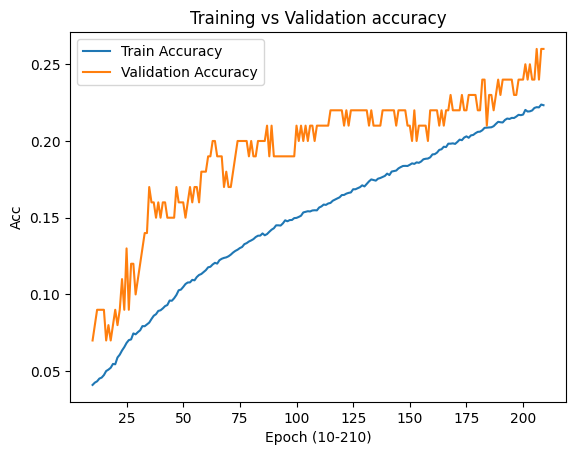

In [ ]:
# Validation vs Accuracy
plt.plot(range(10,210), trainAccuracyPerEpoch, label="Train Accuracy")
plt.plot(range(10,210), np.array(validationAccuracyPerEpoch)[[i*batchNumber for i in range(0, epochs)]], label="Validation Accuracy")
#plt.plot(validationAccuracyPerEpoch, label="Validation Accuracy")
plt.legend()
plt.title("Training vs Validation accuracy")
plt.xlabel("Epoch (10-210)")
plt.ylabel("Accuracy")

##### **C.2 - Test Set**
##### **C.2.1 - Predictions**

In [81]:
# Test set
# Config
batchSize = 100
batchNumber = float(testSet.shape[0]/batchSize).__ceil__()

# Initialise prediction and tests
y_pred = []
y_test = []

# For each batches
begin = time.time()
for batch in range(batchNumber):
    if batch % 10 == 0:
        print(f"Batch {batch}/{batchNumber}, [{time.time()-begin:.5f}s]")
        
    # Load the batch
    images, labels = loadImageBatch(testSet.iloc[batch*batchSize:(batch+1)*batchSize,:])
        
    # Infer the probability for each category
    logits = tf.nn.softmax(model(tf.stack(images)), axis=1)
        
    # Get the results infered by the model
    results = np.asarray(tf.argmax(logits, axis=1)).tolist()
    
    # Store the resuts
    y_pred.extend(results)
    y_test.extend(labels)

Batch 0/35, [0.00000s]
Batch 10/35, [8.92454s]
Batch 20/35, [17.98842s]
Batch 30/35, [26.96680s]


##### **C.2.2 - Confusion Matrix**

In [83]:
# Get the accuracy
print(f"The accuracy for this model is {accuracy_score(y_test, y_pred):.4f}.")

# Transform int to labels
y_testLab = [intToNameDict[i] for i in y_test]
y_predLab = [intToNameDict[i] for i in y_pred]

# Print the results
print(classification_report(y_testLab, y_predLab))

The accuracy for this model is 0.1690.
                        precision    recall  f1-score   support

          Adriana Lima       0.18      0.37      0.24        38
          Alex Lawther       0.37      0.27      0.31        26
    Alexandra Daddario       0.26      0.52      0.34        52
          Alvaro Morte       0.31      0.40      0.35        25
           Amanda Crew       0.00      0.00      0.00        24
          Andy Samberg       0.14      0.05      0.07        42
         Anne Hathaway       0.32      0.17      0.22        48
        Anthony Mackie       0.50      0.48      0.49        29
         Avril Lavigne       0.20      0.22      0.21        37
           Ben Affleck       0.04      0.04      0.04        28
            Bill Gates       0.50      0.36      0.42        22
          Bobby Morley       0.38      0.15      0.22        33
      Brenton Thwaites       0.11      0.05      0.07        37
        Brian J. Smith       0.00      0.00      0.00        24


c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models and Applications\Project\AIModelsAndApplication20252026M1InfoIA\src\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models and Applications\Project\AIModelsAndApplication20252026M1InfoIA\src\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\arnol\Bureau\Université\Cours\Master Informatique - IA - EUR DS4H\AI Models

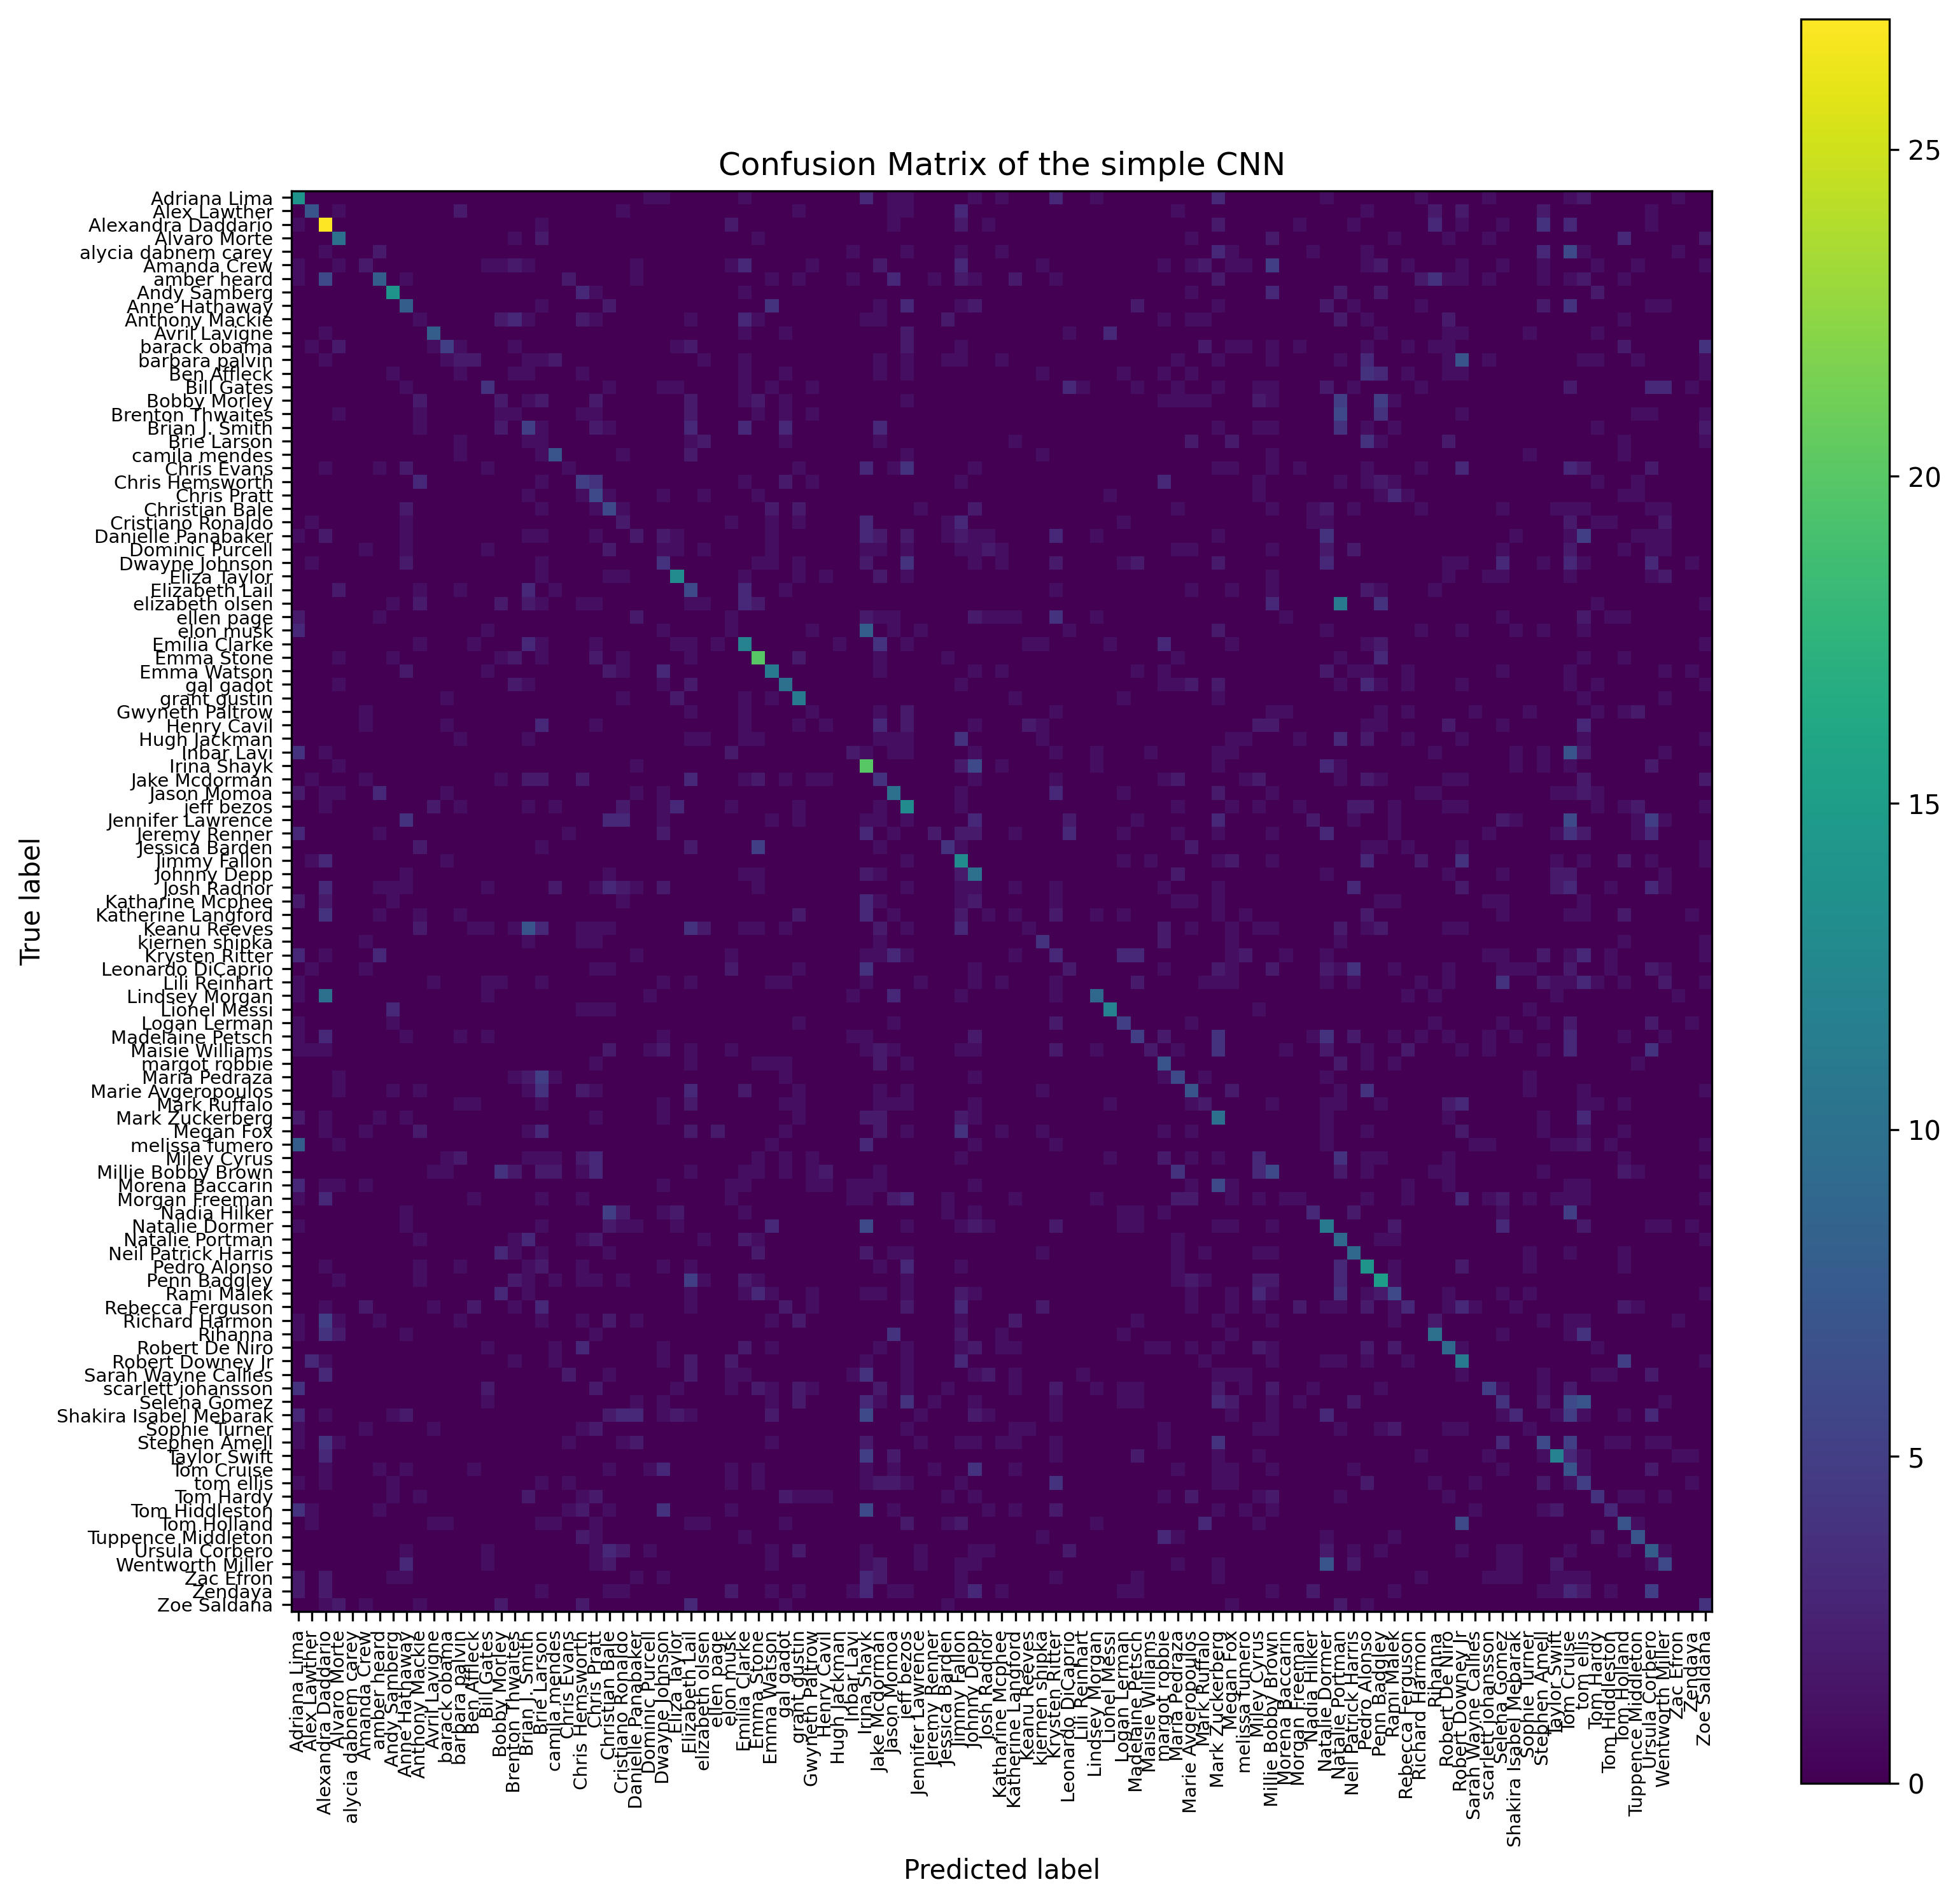

In [104]:
cm = confusion_matrix(y_testLab, y_predLab)
fig, ax = plt.subplots(figsize=(12, 12), dpi=300)
ConfusionMatrixDisplay(
    cm,
    display_labels=list(nameToIntDict.keys())
).plot(
    ax=ax,
    xticks_rotation="vertical",
    include_values=False
)
ax.set_title("Confusion Matrix of the simple CNN")
ax.tick_params(axis='both', labelsize=7)
fig.savefig("CNN Confusion Matrix")